In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import glob
import datetime as dt
from salishsea_tools import viz_tools
from matplotlib.ticker import FormatStrFormatter
import cmocean
from salishsea_tools import viz_tools, evaltools as et
from salishsea_tools import visualisations
import NorthNut as nn
import matplotlib.gridspec as gridspec
import pickle
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.colors as colors
#from matplotlib.mlab import bivariate_normal
import gsw
fs=8 # fs=8
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble =r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')
%matplotlib inline

NorthNut defined variables: ig0,ig1,jg0,jg1,fformat0
NorthNut defined variables: vmask, vmask0, umask, umask0, tmask, fmask, gdept,  gdept_1d, e1t, e2t, e12t, e1f, e2f, e1v, e2u, e3t_1d
NorthNut defined variables: boxCol, colL, colR, arrowwidth, headwidth, headlength, alen, toff, apw, apk


In [2]:
ig0=nn.ig0
ig1=nn.ig1
jg0=nn.jg0
jg1=nn.jg1
tmaskDIAN=nn.tmask
umaskDIAN=nn.umask
vmaskDIAN=nn.vmask

In [3]:
e12t=nn.e12t

In [4]:
def vvl_interp_T_to_V(pe3_in,e1v,e2v,e1t,e2t,vmask,e3t_0,e3v_0):
    # keep extra dimensions in mesh variables
    e12v = e1v[0,:,:]*e2v[0,:,:]
    e12t = e1t[0,:,:]*e2t[0,:,:]
    pe3_out=np.zeros(np.shape(pe3_in))
    pe3_out[:,:,:-1,:-1]=.5*vmask[:,:,:-1,:-1]/e12v[:-1,:-1]*(e12t[:-1,:-1]*(pe3_in[:,:,:-1,:-1]-e3t_0[:,:,:-1,:-1])+e12t[1:,:-1]*(pe3_in[:,:,1:,:-1]-e3t_0[:,:,1:,:-1]))
    pe3_out=pe3_out+e3v_0
    #DO jk = 1, jpk
    #        DO jj = 1, jpjm1
    #           DO ji = 1, fs_jpim1   ! vector opt.
    #              pe3_out(ji,jj,jk) = 0.5_wp * vmask(ji,jj,jk) * r1_e12v(ji,jj)                                   &
    #                 &                       * (   e12t(ji,jj  ) * ( pe3_in(ji,jj  ,jk) - e3t_0(ji,jj  ,jk) )     &
    #                 &                           + e12t(ji,jj+1) * ( pe3_in(ji,jj+1,jk) - e3t_0(ji,jj+1,jk) ) )
    #           END DO
    #        END DO
    #     END DO
    #pe3_out(:,:,:) = pe3_out(:,:,:) + e3v_0(:,:,:)
    return pe3_out

In [5]:
def vvl_interp_T_to_W(pe3_in,e3w_0,e3t_0,tmask):
    pe3_out=np.zeros(np.shape(pe3_in))
    pe3_out[:,0,:,:] = e3w_0[:,0,:,:] + pe3_in[:,0,:,:] - e3t_0[0,:,:]
    pe3_out[:,1:,:,:] = e3w_0[:,1:,:,:]+(1-.5*tmask[:,1:,:,:])*(pe3_in[:,:-1,:,:]-e3t_0[:,:-1,:,:])+.5*tmask[:,1:,:,:]*(pe3_in[:,1:,:,:]-e3t_0[:,1:,:,:])
    #     ! - ML - The use of mask in this formaula enables the special treatment of the last w- point without indirect adressing
    #     DO jk = 2, jpk
    #        pe3_out(:,:,jk) = e3w_0(:,:,jk) + ( 1.0_wp - 0.5_wp * tmask(:,:,jk) ) * ( pe3_in(:,:,jk-1) - e3t_0(:,:,jk-1) )   &
    #           &                            +            0.5_wp * tmask(:,:,jk)   * ( pe3_in(:,:,jk  ) - e3t_0(:,:,jk  ) )
    #     END DO
    return pe3_out

In [6]:
# based on Nancy's code in visualisations.py:
def fill_in(variable, kbathy):
    """For each horizontal point in variable, fill in first vertically masked
    point with the value just above.
    Use mbathy in mesh_mask file to determine level of vertical masking

    :arg variable: the variable to be filled
    :type variable: 2D numpy array

    :arg kbathy: array of index of first bathymetry cell corresponding to variable
    :type variable: 2D numpy array

    :returns: newvar, the filled numpy array
    """
    newvar = np.copy(variable)
    for i, level in enumerate(kbathy):
        newvar[level, i] = variable[level-1, i]
    return newvar

In [7]:
dt.datetime(2015,5,15)+dt.timedelta(days=14*7)

datetime.datetime(2015, 8, 21, 0, 0)

In [8]:
start=dt.datetime(2015,5,15) # use even number of fortnights (6, end is included)
end=dt.datetime(2015,8,20) # end quickly for now- calculations too long
#t0_GLS=dt.datetime(2015,5,11) # start of GLS runs

#start=dt.datetime(2015,5,11) # make sure start and end are consistent between hindcast and GLS files
#end=dt.datetime(2015,5,12) # end quickly for now- calculations too long
mod_basedir='/results/SalishSea/nowcast-green.201812/'
#'/data/eolson/results/MEOPAR/SS36runs/linkHC201812/'
mod_basedir_GLS='/data/eolson/results/MEOPAR/SS36runs/CedarRuns/GLS_Summer15/'
mod_nam_fmt='nowcast'
mod_nam_fmt_GLS='long'
mod_flen=1
mod_flen_GLS=10
saveloc='/data/eolson/results/MEOPAR/SS36runs/calcFiles/NTransport/'
fver='HC201812'

In [9]:
ig0=nn.ig0
ig1=nn.ig1
jg0=nn.jg0
jg1=nn.jg1
tmaskDIAN=nn.tmask
umaskDIAN=nn.umask
vmaskDIAN=nn.vmask

In [10]:
mesh=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc')
#bathyf=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
depthT = mesh.variables['gdept_0'][0, ...]
depthU = mesh.variables['gdepu'][0, ...]
depthV = mesh.variables['gdepv'][0, ...]
depthW = mesh.variables['gdepw_0'][0, ...]
mbathyT=mesh.variables['mbathy'][0,...]
mbathyU=np.sum(mesh.variables['umask'][0,:,:,:],0)
mbathyV=np.sum(mesh.variables['vmask'][0,:,:,:],0)
tmask=mesh.variables['tmask'][:,:,:,:]
vmask=mesh.variables['vmask'][:,:,:,:]
e1t=mesh.variables['e1t'][:,:,:]
e2t=mesh.variables['e2t'][:,:,:]
e1v=mesh.variables['e1v'][:,:,:]
e2v=mesh.variables['e2v'][:,:,:]
e3t_0=mesh.variables['e3t_0'][:,:,:,:]
e3v_0=mesh.variables['e3v_0'][:,:,:,:]
e3w_0=mesh.variables['e3w_0'][:,:,:,:]
navlon=mesh.variables['nav_lon'][:,:]
navlat=mesh.variables['nav_lat'][:,:]

In [11]:
iso90_pts=np.loadtxt('/ocean/eolson/MEOPAR/northernNO3PaperCalcs/notebooks/results/ts90.txt', delimiter=' ', dtype=int)
iso90=np.array([[a,b] for (a,b) in iso90_pts if ((a-644)<130)])
iso90_DIAN=np.array([[a-644,b-112] for (a,b) in iso90])

In [12]:
lat=np.copy(mesh.variables['nav_lat'])
thLatT = lat[iso90[:,0],iso90[:,1]]
dep_thalT, distanceT, thTmask = visualisations.load_thalweg(
            depthT, mesh.variables['tmask'][0,:,:,:], mesh.variables['nav_lon'][:], mesh.variables['nav_lat'][:],
            iso90)

In [13]:
bathyT=np.sum(np.ma.masked_where(mesh.variables['tmask'][0,:,:,:]==0,mesh.variables['e3t_0'][0,:,:,:]),0)
bathyU=np.sum(np.ma.masked_where(mesh.variables['umask'][0,:,:,:]==0,mesh.variables['e3u_0'][0,:,:,:]),0)
bathyV=np.sum(np.ma.masked_where(mesh.variables['vmask'][0,:,:,:]==0,mesh.variables['e3v_0'][0,:,:,:]),0)

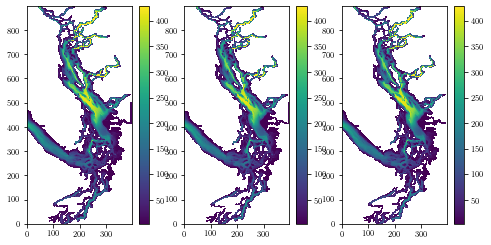

In [14]:
fig,ax=plt.subplots(1,3,figsize=(8,4))
m=ax[0].pcolormesh(bathyT)
fig.colorbar(m,ax=ax[0])
m=ax[1].pcolormesh(bathyV)
fig.colorbar(m,ax=ax[1])
m=ax[2].pcolormesh(bathyU)
fig.colorbar(m,ax=ax[2])

In [15]:
thTmbathy=mbathyT[iso90[:,0],iso90[:,1]]
thUmbathy=mbathyU[iso90[:,0],iso90[:,1]]
thVmbathy=mbathyV[iso90[:,0],iso90[:,1]]

In [16]:
# load from hindcast
fliste3t=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'carp_T',1)
flistU=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'grid_U',1)
flistV=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'grid_V',1)
flistW=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'grid_W',1)
flistT=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'grid_T',1)
flistB=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'ptrc_T',1)
flistNW=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'dian_W',1)
flistNU=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'dian_U',1)
flistNV=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'dian_V',1)
flistR=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'prod_T',1)

ftype=dian_W, are you sure? (if yes, add to list)
ftype=dian_U, are you sure? (if yes, add to list)
ftype=dian_V, are you sure? (if yes, add to list)
ftype=prod_T, are you sure? (if yes, add to list)


In [17]:
recalc=False
if recalc==True:
    PAR_i=list()
    NO3_i=list()
    tc_i=list()
    for iif in range(0,len(flistT)):
        print('iif=',iif)
        with nc.Dataset(flistB.loc[iif,['paths']].values[0]) as fB,\
                  nc.Dataset(fliste3t.loc[iif,['paths']].values[0]) as fR:
            # extract fields to numpy variables for faster transect extraction:
            PARe=np.copy(fR.variables['PAR'][:,:,jg0:jg1,ig0:ig1])*tmask[:,:,jg0:jg1,ig0:ig1]
            NO3e=np.copy(fB.variables['nitrate'][:,:,jg0:jg1,ig0:ig1])*tmask[:,:,jg0:jg1,ig0:ig1]
            tc_i.append(fB.variables['time_centered'][:])
        PAR_i.append(PARe[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
        NO3_i.append(NO3e[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]])

    PAR=np.concatenate(PAR_i,axis=0)
    NO3=np.concatenate(NO3_i,axis=0)
    with open('../../save/isobathNO3PAR.pkl','wb') as ff:
        pickle.dump([PAR,NO3],ff)
else:
    with open('../../save/isobathNO3PAR.pkl','rb') as ff:
        [PAR,NO3]=pickle.load(ff)

In [18]:
recalc=False
if recalc==True:
    sti=list()
    sti1=list()
    sti2=list()
    e3t_i=list()
    e3v_i=list()
    tc_i=list()
    e3ta_i=list()
    rho_i=list()
    for iif in range(0,len(flistT)):
        print('iif=',iif)
        with nc.Dataset(fliste3t.loc[iif,['paths']].values[0]) as fe3t,\
                  nc.Dataset(flistT.loc[iif,['paths']].values[0]) as fT:
            # extract fields to numpy variables for faster transect extraction:
            sshe=np.copy(fT.variables['sossheig'][:,jg0:jg1,ig0:ig1])
            e3te=np.copy(fe3t.variables['e3t'][:,:,jg0:jg1,ig0:ig1])*tmask[:,:,jg0:jg1,ig0:ig1]
            tc_i.append(fT.variables['time_centered'][:])
            SAe=fT.variables['vosaline'][:,:,jg0:jg1,ig0:ig1]
            CTe=fT.variables['votemper'][:,:,jg0:jg1,ig0:ig1]
            rhoe=gsw.sigma0(SAe,CTe)
        e3ve=vvl_interp_T_to_V(e3te,e1v[:,jg0:jg1,ig0:ig1],e2v[:,jg0:jg1,ig0:ig1],
                              e1t[:,jg0:jg1,ig0:ig1],e2t[:,jg0:jg1,ig0:ig1],
                              vmask[:,:,jg0:jg1,ig0:ig1],e3t_0[:,:,jg0:jg1,ig0:ig1],e3v_0[:,:,jg0:jg1,ig0:ig1])
        # 1st extract Discovery mouth transect for diagnosing tidal phase:
        sti.append(np.sum(tmaskDIAN[0,93,9:16]*sshe[:,93,9:16],1)/np.sum(tmaskDIAN[0,93,9:16]))
        sti1.append(sshe[:,iso90_DIAN[-1,0],iso90_DIAN[-1,1]])
        sti2.append(sshe[:,iso90_DIAN[0,0],iso90_DIAN[0,1]])
        e3t_i.append(e3te[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
        e3ta_i.append(e3te[:,:,:,:])
        e3v_i.append(e3ve[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
        rho_i.append(rhoe[:,:, iso90_DIAN[:, 0], iso90_DIAN[:, 1]])

    st=np.concatenate(sti,axis=0)
    st1=np.concatenate(sti1,axis=0)
    st2=np.concatenate(sti2,axis=0)
    e3t=np.concatenate(e3t_i,axis=0)
    e3ta=np.concatenate(e3ta_i,axis=0)
    e3v=np.concatenate(e3v_i,axis=0)
    tc=np.concatenate(tc_i,axis=0)
    sigma0=np.concatenate(rho_i,axis=0)
    del sti, sti1, sti2, e3t_i, tc_i,rho_i


    PPTot_i=list()
    app_i=list()
    BPPTot_i=list()
    Bapp_i=list()

    for iif in range(0,len(flistV)):
        print('iif=',iif)
        with nc.Dataset(flistR.loc[iif,['paths']].values[0]) as fR:
            # extract fields to numpy variables for faster transect extraction:'GLS_G', 'GLS_P', 'eps', 'bfN2',rhop
            PPDiate=np.copy(fR['PPDIATNO3'][:,:,jg0:jg1,ig0:ig1])
            PPMrube=np.copy(fR['PPMRUBNO3'][:,:,jg0:jg1,ig0:ig1])
            PPPhye=np.copy(fR['PPPHYNO3'][:,:,jg0:jg1,ig0:ig1])
            BPPDiate=np.copy(fR['PPDIAT'][:,:,jg0:jg1,ig0:ig1])
            BPPMrube=np.copy(fR['PPMRUB'][:,:,jg0:jg1,ig0:ig1])
            BPPPhye=np.copy(fR['PPPHY'][:,:,jg0:jg1,ig0:ig1])
        PPTot_i.append(PPDiate[:,:,iso90_DIAN[:, 0], iso90_DIAN[:, 1]]+\
                       PPMrube[:,:,iso90_DIAN[:, 0], iso90_DIAN[:, 1]]+\
                       PPPhye[:,:,iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
        BPPTot_i.append(BPPDiate[:,:,iso90_DIAN[:, 0], iso90_DIAN[:, 1]]+\
                       BPPMrube[:,:,iso90_DIAN[:, 0], iso90_DIAN[:, 1]]+\
                       BPPPhye[:,:,iso90_DIAN[:, 0], iso90_DIAN[:, 1]])
        app_i.append(PPDiate[:,:,:,:]+PPMrube[:,:,:,:]+PPPhye[:,:,:,:])
        Bapp_i.append(BPPDiate[:,:,:,:]+BPPMrube[:,:,:,:]+BPPPhye[:,:,:,:])
    PPTot=np.concatenate(PPTot_i,axis=0)
    AIPP=np.sum(np.concatenate(app_i,axis=0)*e3ta,1)
    AIPPZ=np.concatenate(app_i,axis=0)*e3ta[:,:,:,:]*np.expand_dims(tmaskDIAN[:,:,:],0)
    AIPP6=np.sum(AIPPZ[:,:6,:,:],1)
    AIPPMean=np.mean(AIPP,0)
    PPTotMean=np.mean(PPTot,0)
    sig0Mean=np.mean(sigma0,0)
    AIPPSTD=np.std(AIPP,0)
    PPTotSTD=np.std(PPTot,0)
    sig0STD=np.std(sigma0,0)
    
    BPPTot=np.concatenate(BPPTot_i,axis=0)
    BAIPP=np.sum(np.concatenate(Bapp_i,axis=0)*e3ta,1)
    BAIPPZ=np.concatenate(Bapp_i,axis=0)*e3ta[:,:,:,:]*np.expand_dims(tmaskDIAN[:,:,:],0)
    BAIPP6=np.sum(BAIPPZ[:,:6,:,:],1)
    BAIPPMean=np.mean(BAIPP,0)
    BPPTotMean=np.mean(BPPTot,0)
    BAIPPSTD=np.std(BAIPP,0)
    BPPTotSTD=np.std(BPPTot,0)
    with open('/data/eolson/MEOPAR/biomodelevalpaper/figsNNut/isobathAerialPP.pkl','wb') as ff:
        pickle.dump([AIPPMean,AIPP6,PPTotMean,sig0Mean,AIPPSTD,PPTotSTD,sig0STD,
                     BAIPPMean,BAIPP6,BPPTotMean,BAIPPSTD,BPPTotSTD],ff)
else:
    with open('/data/eolson/MEOPAR/biomodelevalpaper/figsNNut/isobathAerialPP.pkl','rb') as ff:
        [AIPPMean,AIPP6,PPTotMean,sig0Mean,AIPPSTD,PPTotSTD,sig0STD,
            BAIPPMean,BAIPP6,BPPTotMean,BAIPPSTD,BPPTotSTD]=pickle.load(ff)

In [19]:
bgcol='Wheat'
cm1=cmocean.cm.tempo

In [20]:
np.shape(PAR),np.shape(NO3)

((2352, 40, 105), (2352, 40, 105))

In [21]:
PARmean=np.mean(PAR,0)

In [22]:
LL=PARmean/PARmean[0,:]

In [23]:
np.shape(LL)

(40, 105)

In [24]:
NO3mean=np.mean(NO3,0)

In [25]:
np.shape(NO3mean)

(40, 105)

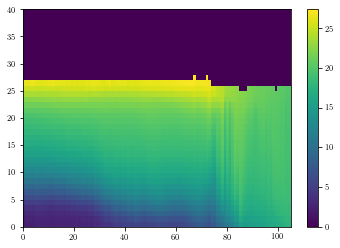

In [26]:
plt.pcolormesh(NO3mean)
plt.colorbar()

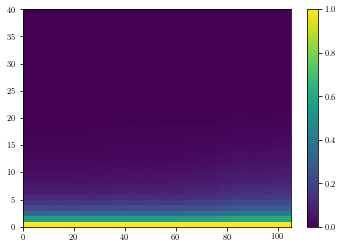

In [27]:
plt.pcolormesh(LL)
plt.colorbar()

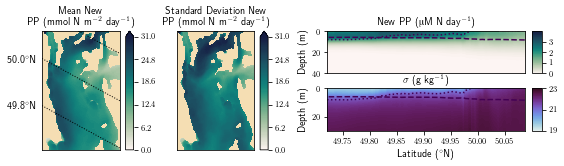

In [28]:
fig = plt.figure(figsize=(8,2.2))
gs0 = gridspec.GridSpec(1,3,left=.08,right=.95,wspace=.3,bottom=.08,top=.83,width_ratios=[1,1,2.5])
gs1=gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=gs0[0],width_ratios=[10,1],wspace=.1)
gs2=gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=gs0[1],width_ratios=[10,1],wspace=.1)
gs3=gridspec.GridSpecFromSubplotSpec(3,3,subplot_spec=gs0[2],width_ratios=[1,20,1],height_ratios=[1,1,.1],wspace=.1,hspace=.5)
ax1=fig.add_subplot(gs1[0])
ax2=fig.add_subplot(gs2[0])
ax3=fig.add_subplot(gs3[0,1])
ax4=fig.add_subplot(gs3[1,1])
cbax1=fig.add_subplot(gs1[1])
cbax2=fig.add_subplot(gs2[1])
cbax3=fig.add_subplot(gs3[0,2])
cbax4=fig.add_subplot(gs3[1,2])
viz_tools.set_aspect(ax1)
viz_tools.set_aspect(ax2)
ax1.set_facecolor(bgcol)
ax2.set_facecolor(bgcol)

iax=ax1 # PP Mean
cbax=cbax1
clim=[0,31]
#clim=[0,28]
iax.set_facecolor(bgcol)
mesh0=iax.contourf(np.ma.masked_where(tmask[0,0,jg0:jg1,ig0:ig1]==0,AIPPMean*24*3600*1.11),
                   np.linspace(clim[0],clim[1],101),vmin=clim[0],vmax=clim[1],
                         cmap=cmocean.cm.tempo,extend='max')
for c in mesh0.collections:
    c.set_edgecolor("face")
iax.contour(navlat[jg0:jg1,ig0:ig1],levels=(49.8,50,50.2),colors='k',linewidths=1,linestyles=':')
iax.annotate('49.8$^{\circ}$N',(-43,45),annotation_clip=False)
iax.annotate('50.0$^{\circ}$N',(-43,95),annotation_clip=False)
cb=fig.colorbar(mesh0,cax=cbax,ticks=np.linspace(clim[0],clim[1],6))
iax.set_title('Mean New\nPP (mmol N m$^{-2}$ day$^{-1}$)',fontsize=10)


iax=ax2 # PP Mean
cbax=cbax2
clim=[0,31]
#clim=[0,28]
mesh0=iax.contourf(np.ma.masked_where(tmask[0,0,jg0:jg1,ig0:ig1]==0,AIPPSTD*24*3600*1.11),
                   np.linspace(clim[0],clim[1],101),vmin=clim[0],vmax=clim[1],
                         cmap=cmocean.cm.tempo,extend='max')
for c in mesh0.collections:
    c.set_edgecolor("face")
cb=fig.colorbar(mesh0,cax=cbax,ticks=np.linspace(clim[0],clim[1],6))
iax.set_title('Standard Deviation New\nPP (mmol N m$^{-2}$ day$^{-1}$)',fontsize=10)

iax=ax3 # PP Mean
cbax=cbax3
extend='neither'
pcol='grey'
amp=4#3.5
m=iax.contourf(thLatT, dep_thalT[:,0],fill_in(PPTotMean*24*3600*1.11, thTmbathy),vmin=0,vmax=amp,
              levels=np.linspace(0,amp,101),cmap=cmocean.cm.tempo,extend='neither')
for c in m.collections:
    c.set_edgecolor("face")
m2=iax.contour(thLatT, dep_thalT[:,0],fill_in(LL,thTmbathy),levels=[.1,],linestyles='--')
m3=iax.contour(thLatT, dep_thalT[:,0],fill_in(NO3mean,thTmbathy),levels=[10,],linestyles=':')
visualisations._add_bathy_patch(distanceT,bathyT,iso90,iax,pcol)
iax.set_ylim(40,0)
cb=fig.colorbar(m,cax=cbax)
cb.set_ticks((0,1,2,3))
iax.set_title('New PP ($\muup$M N day$^{-1}$)',fontsize=10)
#iax.set_title('New PP ($\mu$M N day$^{-1}$)',fontsize=10)
iax.set_ylabel('Depth (m)',fontsize=10)


iax=ax4 
cbax=cbax4
extend='neither'
pcol='grey'
clim=[19,23]
m=iax.contourf(thLatT, dep_thalT[:,0],fill_in(sig0Mean, thTmbathy),vmin=clim[0],vmax=clim[1],
              levels=np.linspace(clim[0],clim[1],101),cmap=cmocean.cm.dense)
for c in m.collections:
    c.set_edgecolor("face")
m2=iax.contour(thLatT, dep_thalT[:,0],fill_in(LL,thTmbathy),levels=[.1,],linestyles='--')
m3=iax.contour(thLatT, dep_thalT[:,0],fill_in(NO3mean,thTmbathy),levels=[10,],linestyles=':')
visualisations._add_bathy_patch(distanceT,bathyT,iso90,iax,pcol)
iax.set_ylim(30,0)
cb=fig.colorbar(m,cax=cbax)
cb.set_ticks((19,21,23))
iax.set_title('$\sigma$ (g kg$^{-1}$)',fontsize=10)
iax.set_xlabel('Latitude ($^{\circ}$N)',fontsize=10)
iax.set_ylabel('Depth (m)',fontsize=10)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)

fig.savefig('/data/eolson/MEOPAR/biomodelevalpaper/response/PPR2.png',dpi = 200, transparent=False)
fig.savefig('/data/eolson/MEOPAR/biomodelevalpaper/response/PPR2.eps',dpi = 300, transparent=False)

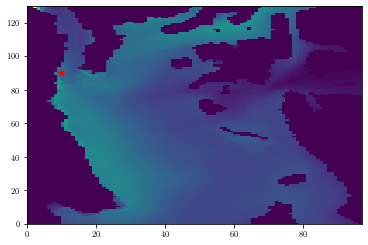

In [29]:
plt.pcolormesh(np.mean(AIPP6*e12t,0))
plt.plot(10,90,'r*')

In [30]:
#mol/s, total area NO3 prod
np.sum(np.sum(np.mean(AIPP6*e12t,0),1),0)*1e-3

164.76381035709372

In [31]:
#mol/s, total area NO3 prod
np.sum(np.sum(np.mean(AIPP6*e12t,0),1),0)*1e-3*1.11

182.88782949637405

In [32]:
#mol/s, total area NO3 prod
np.sum(np.sum(np.mean(AIPP6[:,:-3,:]*e12t[:-3,:],0),1),0)*1e-3

162.49150666081343

In [33]:
#mol/s, total area NO3 prod
np.sum(np.sum(np.mean(AIPP6[:,:-3,:]*e12t[:-3,:],0),1),0)*1e-3*1.11

180.36557239350293

In [34]:
#mol/s, total area all prod
np.sum(np.sum(np.mean(BAIPP6*e12t,0),1),0)*1e-3

250.5251074505402

In [35]:
#mol/s, total area all prod
np.sum(np.sum(np.mean(BAIPP6*e12t,0),1),0)*1e-3*1.11

278.08286927009965

In [36]:
#mol/s, total area all prod
np.sum(np.sum(np.mean(BAIPP6[:,:-3,:]*e12t[:-3,:],0),1),0)*1e-3

247.63711867330247

In [37]:
#mol/s, total area all prod
np.sum(np.sum(np.mean(BAIPP6[:,:-3,:]*e12t[:-3,:],0),1),0)*1e-3*1.11

274.8772017273658

In [38]:
iso90_DIAN[3,0]

14

In [39]:
r90mask=np.copy(tmaskDIAN[0,:,:])
r90mask[:iso90_DIAN[3,0],:]=0
r90mask[91:,:]=0
jj=iso90_DIAN[3,0]
ind=3
while jj<91:
    r90mask[iso90_DIAN[ind,0],(iso90_DIAN[ind,1]+1):]=0
    ind=ind+1
    jj=iso90_DIAN[ind,0]

In [40]:
rmask=np.copy(tmaskDIAN[0,:,:])
rmask[:thw_DIAN[3,0],:]=0
rmask[91:,:]=0
jj=thw_DIAN[3,0]
ind=3
while jj<91:
    rmask[thw_DIAN[ind,0],(thw_DIAN[ind,1]+1):]=0
    ind=ind+1
    jj=thw_DIAN[ind,0]

NameError: name 'thw_DIAN' is not defined

In [ ]:
r2mask=np.copy(tmaskDIAN[0,:,:])
r2mask[:iso90_DIAN[3,0],:]=0
r2mask[91:,:]=0

In [ ]:
iso90_DIAN[-1,0]

In [ ]:
plt.pcolormesh(rmask)
plt.plot(thw_DIAN[:,1],thw_DIAN[:,0],'r-')
plt.plot(iso90_DIAN[:,1],iso90_DIAN[:,0],'c-')

In [ ]:
plt.pcolormesh(tmaskDIAN[0,:,:])

In [ ]:
np.sum(rmask*e12t)/np.sum(r2mask*e12t)

In [ ]:
np.sum(rmask*e12t*BAIPPMean)/np.sum(r2mask*e12t*BAIPPMean)

In [ ]:
np.sum(rmask*e12t*AIPPMean)/np.sum(r2mask*e12t*AIPPMean)

In [ ]:
np.sum(r90mask*e12t)/np.sum(r2mask*e12t)

In [ ]:
np.sum(r90mask*e12t*BAIPPMean)/np.sum(r2mask*e12t*BAIPPMean)

In [ ]:
np.sum(r90mask*e12t*AIPPMean)/np.sum(r2mask*e12t*AIPPMean)